In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapiq.explainer import TabularExplainer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import shapiq_student
from shapiq_student.wknn_explainer2 import Weighted


In [2]:
df = pd.read_csv("shapiq_student/movie_dataset.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train = train_df[["fight_scenes","kiss_scenes"]].values
y_train = train_df["label"].values
X_test = test_df[["fight_scenes","kiss_scenes"]].values
y_test = test_df["label"].values

In [3]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

In [4]:
row = df[df['title'] == 'Revenge Protocol'].iloc[0]
x_val = [row['fight_scenes'], row['kiss_scenes']]
y_val = row['label']

In [5]:
explainer = Weighted(X_train, y_train, "weighted")

In [6]:
phi = explainer.weighted_knn_shapley(
    x_val=x_val, y_val=y_val,
    gamma=5, K=5)

In [7]:
print(phi)

[ 1.25105610e+00  1.25105610e+00  1.25105610e+00  1.25105610e+00
  1.25105610e+00  2.51056098e-01  8.43894310e-02  3.67703834e-02
  1.89132405e-02  1.09767326e-02  7.00847864e-03  4.84397647e-03
 -2.88275553e-02  2.96045561e-02  3.01040566e-02  3.04370569e-02
  3.06659946e-02  3.08275977e-02  3.09443111e-02  3.10303104e-02
  3.10948099e-02  3.11439524e-02  3.11819261e-02  3.12116446e-02
  3.12351718e-02  3.12539936e-02  3.12691958e-02  3.12815828e-02
  3.12917578e-02  3.13001785e-02  3.13071957e-02  3.13130812e-02
 -1.09085853e-03]


In [8]:
from shapiq_student.wknn_explainer2 import Weighted

gamma = 5
K = 5

explainer = Weighted(X_train, y_train, "weighted")

own_phi = explainer.weighted_knn_shapley(
    x_val=x_val, y_val=y_val,
    gamma=gamma, K=K)

print("Eigene Weighted-KNN Shapley Werte:")
print(own_phi)


Eigene Weighted-KNN Shapley Werte:
[ 1.25105610e+00  1.25105610e+00  1.25105610e+00  1.25105610e+00
  1.25105610e+00  2.51056098e-01  8.43894310e-02  3.67703834e-02
  1.89132405e-02  1.09767326e-02  7.00847864e-03  4.84397647e-03
 -2.88275553e-02  2.96045561e-02  3.01040566e-02  3.04370569e-02
  3.06659946e-02  3.08275977e-02  3.09443111e-02  3.10303104e-02
  3.10948099e-02  3.11439524e-02  3.11819261e-02  3.12116446e-02
  3.12351718e-02  3.12539936e-02  3.12691958e-02  3.12815828e-02
  3.12917578e-02  3.13001785e-02  3.13071957e-02  3.13130812e-02
 -1.09085853e-03]


In [9]:
import numpy as np
import itertools
from sklearn.neighbors import KNeighborsClassifier

def brute_force_shapley(X_train, y_train, x_val, y_val, K=5):
    N = len(X_train)
    shapley_values = np.zeros(N)

    all_indices = list(range(N))
    
    for perm in itertools.permutations(all_indices):
        knn_set = []
        labels_set = []
        prev_prediction = 0.5  # Baseline prediction (can be adjusted)

        for idx in perm:
            knn_set.append(X_train[idx])
            labels_set.append(y_train[idx])
            
            # Build KNN classifier on current coalition
            current_K = min(K, len(knn_set))
            knn = KNeighborsClassifier(n_neighbors=current_K)
            knn.fit(knn_set, labels_set)
            current_prediction = knn.predict([x_val])[0]

            # Contribution of idx
            marginal_contribution = int(current_prediction == y_val) - int(prev_prediction == y_val)
            shapley_values[idx] += marginal_contribution

            prev_prediction = current_prediction

    # Average over all permutations
    shapley_values /= np.math.factorial(N)
    
    return shapley_values


In [13]:
# Nehme nur kleine Teilmenge für Brute-Force (sonst dauert es zu lange!)
small_train_df = train_df.sample(8, random_state=0)
X_small = small_train_df[["fight_scenes", "kiss_scenes"]].values
y_small = small_train_df["label"].values

# Wähle ein Testbeispiel
row = df[df['title'] == 'Revenge Protocol'].iloc[0]
x_val = [row['fight_scenes'], row['kiss_scenes']]
y_val = row['label']

# Berechne Brute-Force Shapley Values
phi_brute = brute_force_shapley(X_small, y_small, x_val, y_val, K=5)

print("Brute-Force Shapley Values:")
print(phi_brute)


Brute-Force Shapley Values:
[-0.09642857  0.49404762 -0.09642857 -0.09642857  0.49404762 -0.09642857
  0.49404762 -0.09642857]


C:\Users\Test\AppData\Local\Temp\ipykernel_7136\2615052139.py:33: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  shapley_values /= np.math.factorial(N)


In [14]:
explainer = Weighted(X_small, y_small, method="weighted")
phi_weighted = explainer.weighted_knn_shapley(x_val, y_val, gamma=5, K=5)

print("Weighted KNN-Shapley Values:", phi_weighted)


Weighted KNN-Shapley Values: [ 1.26904762  1.26904762  1.05833333 -1.05833333 -1.05833333 -0.05833333
  0.10833333 -0.0547619 ]


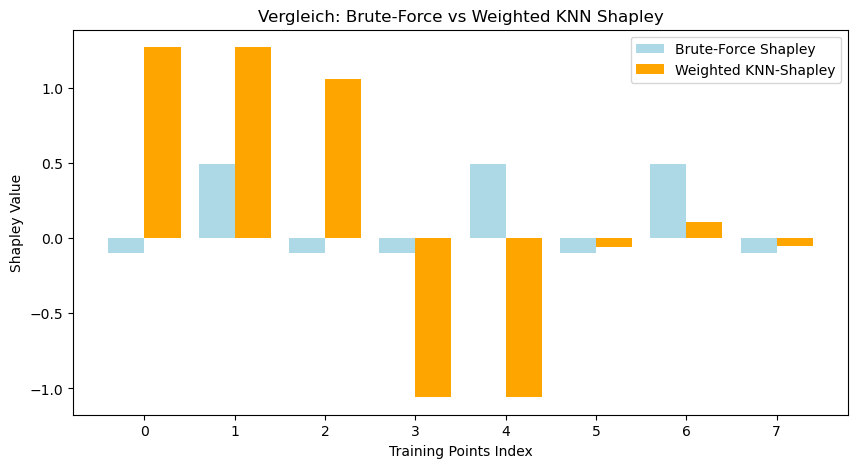

In [15]:
min_len = min(len(phi_brute), len(phi_weighted))
x = np.arange(min_len)

plt.figure(figsize=(10,5))
plt.bar(x - 0.2, phi_brute[:min_len], width=0.4, label="Brute-Force Shapley", color="lightblue")
plt.bar(x + 0.2, phi_weighted[:min_len], width=0.4, label="Weighted KNN-Shapley", color="orange")

plt.xlabel("Training Points Index")
plt.ylabel("Shapley Value")
plt.title("Vergleich: Brute-Force vs Weighted KNN Shapley")
plt.legend()
plt.show()
